## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os

from unet import unet
from utils.dataset_utils import load_dataset_split, save_images, load_images_from_list
from utils.preprocessing import merge_patches_directly_and_save_all
from utils.vis_utils import plot_image_mask_prediction

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### 1.1 Parameters of the experiment (and hyperparameters from ../config.py)

In [4]:
UNET_NAME = 'UNet_RGB'
EXPERIMENT_NAME = f'icoseg_subset_80/{UNET_NAME}'
DATASET_PATH = '../datasets/icoseg/subset_80'

In [5]:
CHECKPOINTS_PATH = f'../checkpoints'
CHECKPOINT_FILENAME = f'{CHECKPOINTS_PATH}/{EXPERIMENT_NAME}/{UNET_NAME}.hdf5'
LOGS_PATH = f'../logs'
LOGS_FILENAME = f'{LOGS_PATH}/{EXPERIMENT_NAME}.json'
RESULTS_PATH = f'../results/{EXPERIMENT_NAME}'

## 2. Load the dataset splits

In [6]:
train_images, train_masks, train_img_names = load_dataset_split(DATASET_PATH, 'train')
val_images, val_masks, val_img_names = load_dataset_split(DATASET_PATH, 'val')
test_images, test_masks, test_img_names = load_dataset_split(DATASET_PATH, 'test')

train_masks = train_masks[..., np.newaxis]
val_masks = val_masks[..., np.newaxis]
test_masks = test_masks[..., np.newaxis]

print(train_images.shape, train_images.dtype, train_images.min(), train_images.max())
print(val_images.shape, val_images.dtype, val_images.min(), val_images.max())
print(val_img_names[:3])

(50, 512, 512, 3) float64 0.0 1.0
(10, 512, 512, 3) float64 0.0 1.0
['2601177796_b8e280ac8a_334_500_0_0.png', '2802725781_52d0e4061a_500_336_0_0.png', '2803811473_1ba769690b_327_500_0_0.png']


## 3. Make some predictions with the best model

### Remember:
1. we used patches (not initial images) for the training part;
2. accuracy is not a good metric for image segmentation evaluation (patches with small objects can have good accuracies with zero prediction for all pixels).

### 3.1 Load the best_model

In [7]:
best_model = unet(input_shape=config.INPUT_SHAPE,
                  pretrained_weights=CHECKPOINT_FILENAME)

### 3.2 Predict

In [8]:
%%time
train_preds = best_model.predict(train_images, batch_size=3).squeeze()
val_preds = best_model.predict(val_images, batch_size=3).squeeze()
test_preds = best_model.predict(test_images, batch_size=3).squeeze()

CPU times: user 34.3 s, sys: 8.1 s, total: 42.4 s
Wall time: 41.8 s


In [9]:
print(test_preds.shape, test_preds.dtype, test_preds.min(), test_preds.max())
print(train_img_names[:3])
print(val_img_names[:3])
print(test_img_names[:3])

(20, 512, 512) float32 5.1584385e-20 0.9995277
['1403964539_08e241e595_333_500_0_0.png', '1438937169_ef6699fcfd_323_500_0_0.png', '2116804372_952ba99189_375_500_0_0.png']
['2601177796_b8e280ac8a_334_500_0_0.png', '2802725781_52d0e4061a_500_336_0_0.png', '2803811473_1ba769690b_327_500_0_0.png']
['2600169273_203ece0ed7_333_500_0_0.png', '2600221691_528280b36a_333_500_0_0.png', '2600999392_81df2c3baa_334_500_0_0.png']


### 3.3 Save all predictions (patches, not initial images)

In [10]:
train_preds_uint8 = (255*train_preds).round().astype(np.uint8)
val_preds_uint8 = (255*val_preds).round().astype(np.uint8)
test_preds_uint8 = (255*test_preds).round().astype(np.uint8)

save_images(train_preds_uint8, train_img_names, f'{RESULTS_PATH}/train/train_pred_patches')
save_images(val_preds_uint8, val_img_names, f'{RESULTS_PATH}/val/val_pred_patches')
save_images(test_preds_uint8, test_img_names, f'{RESULTS_PATH}/test/test_pred_patches')

/home/tudor/anaconda2/envs/py36_tensorflow/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../results/icoseg_subset_80/UNet_RGB/test/test_pred_patches/2808213027_528dce87f7_286_500_0_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


### 3.4 Merge patches and save images_from_patches

In [11]:
merge_patches_directly_and_save_all(RESULTS_PATH,
                                    split_types=['pred'],
                                    img_format='png')

### 3.5 Plot some results

In [12]:
# train batch
train_images_path = f'{DATASET_PATH}/train/train_img_from_patches'
train_masks_path = f'{DATASET_PATH}/train/train_mask_from_patches'
train_preds_path = f'{RESULTS_PATH}/train/train_pred_from_patches'

train_names_batch = os.listdir(train_preds_path)[:3]
train_images_batch = load_images_from_list(train_names_batch, train_images_path) / 255.
train_masks_batch = load_images_from_list(train_names_batch, train_masks_path) / 255.
train_preds_batch = load_images_from_list(train_names_batch, train_preds_path) / 255.

# test batch
test_images_path = f'{DATASET_PATH}/test/test_img_from_patches'
test_masks_path = f'{DATASET_PATH}/test/test_mask_from_patches'
test_preds_path = f'{RESULTS_PATH}/test/test_pred_from_patches'

test_names_batch = os.listdir(test_preds_path)[5:9]
test_images_batch = load_images_from_list(test_names_batch, test_images_path) / 255.
test_masks_batch = load_images_from_list(test_names_batch, test_masks_path) / 255.
test_preds_batch = load_images_from_list(test_names_batch, test_preds_path) / 255.

dataset_split: train


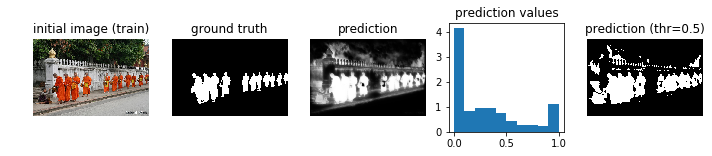

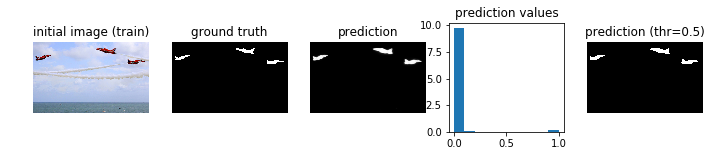

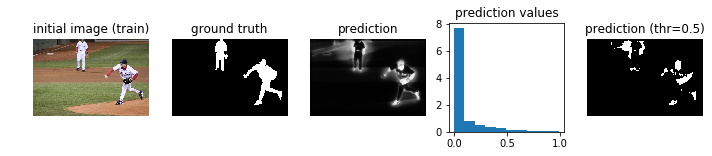

dataset_split: test


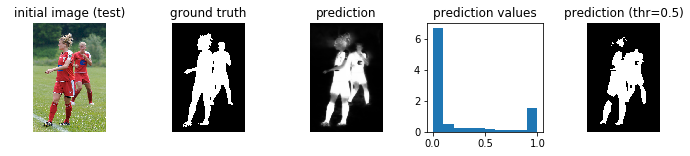

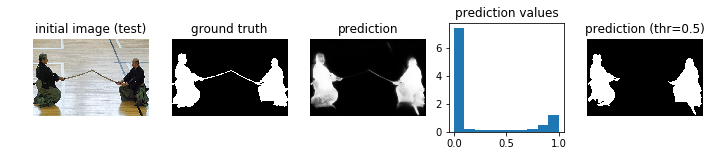

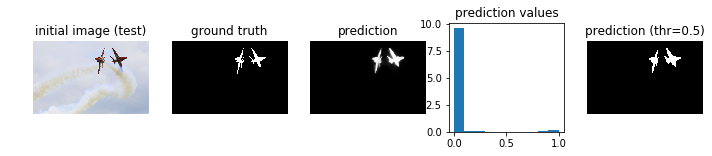

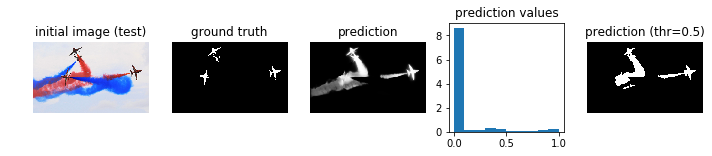

In [13]:
plot_image_mask_prediction(train_images_batch, train_masks_batch, train_preds_batch,
                           dataset_split='train', pred_thr=config.PRED_THR)
plot_image_mask_prediction(test_images_batch, test_masks_batch, test_preds_batch,
                           dataset_split='test', pred_thr=config.PRED_THR)